<a href="https://colab.research.google.com/github/AdrianUrbanski/MOTSP/blob/main/NSGA_II_raport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init

Uwaga:  
Runtime type powinien być ustawiony na GPU od początku, ale w wypadku pojawienia się jakichś błędów jest to pierwsza rzeczy którą warto sprawdzić.

In [1]:
pip install tsplib95

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
from numba import jit
import tsplib95
import tsplib95 as tsp
from tqdm.auto import tqdm
import time
from scipy.spatial.distance import cdist
from IPython.display import clear_output
import multiprocessing as mp
from google.colab import output
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D

# NSGA-II

## Kernele CUDA

In [3]:
@cuda.jit
def check_domination(pop_vals, dominated, dom_count):
    q, p = cuda.grid(2)

    pop_size = pop_vals.shape[0]
    if (p >= pop_size) or (q >= pop_size):
        return

    if (pop_vals[p][0] <= pop_vals[q][0] and pop_vals[p][1] <= pop_vals[q][1] and
        (pop_vals[p][0] < pop_vals[q][0] or pop_vals[p][1] < pop_vals[q][1])):
        dominated[p, q] = 1

    elif (pop_vals[q][0] <= pop_vals[p][0] and pop_vals[q][1] <= pop_vals[p][1] and
            (pop_vals[q][0] < pop_vals[p][0] or pop_vals[q][1] < pop_vals[p][1])):
        cuda.atomic.add(dom_count, p, 1)


@cuda.jit
def find_first_frontier(dom_count, frontier, rank):
    p = cuda.grid(1)
    if dom_count[p] == 0:
        frontier[p] = 1
        rank[p] = 1


@cuda.jit
def remove_current_frontier(dominated, dom_count, current_rank,
                            current_frontier, next_frontier, rank):
    q, p = cuda.grid(2)

    pop_size = dominated.shape[0]
    if (p >= pop_size) or (q >= pop_size) or current_frontier[p] == 0:
        return
    
    if dominated[p, q] == 1:
        if cuda.atomic.add(dom_count, q, -1) == 1:
            rank[q] = current_rank
            next_frontier[q] = 1

## Algorytm

In [4]:
class NSGA_II_GPU:
    def __init__(self, chromosome_length, population_size, objectives_number,
                 initial_population, initial_objective_values, best_kept=0):
        self.chromosome_length = chromosome_length
        self.population_size = population_size
        self.best_kept = best_kept
        self.objectives_number = objectives_number
        self.kept_size = best_kept*objectives_number
        if type(initial_population) is not np.ndarray:
            raise ValueError("initial population must be a numpy array")
        if initial_population.shape != (self.population_size + self.kept_size,
                                        self.chromosome_length):
            raise ValueError("initial population must be of shape (population_size, chromosome_length)")
        self.current_population = initial_population
        if type(initial_objective_values) is not np.ndarray:
            raise ValueError("initial objective values must be a numpy array")
        if initial_objective_values.shape != (self.population_size + self.kept_size,
                                              self.objectives_number):
            raise ValueError("initial population values must be of shape (population_size, objectives_number)")
        self.current_objective_values = initial_objective_values
        self.current_pareto_frontier = np.empty(self.population_size)
        self.current_crowding_distances = np.empty(self.population_size)
        self.replace_population(None, None)


    def get_population(self):
        return self.current_population


    def get_values(self):
        return self.current_objective_values


    def non_dominated_sort(self, pop_vals):

        def is_not_empty(frontier):
            return np.any(frontier == 1)

        pop_size = pop_vals.shape[0]

        current_frontier = np.zeros(pop_size, dtype='bool')
        next_frontier = np.zeros(pop_size, dtype='bool')
        current_rank = 1

        dom = np.zeros((pop_size, pop_size), dtype='bool')
        dom_count = np.zeros(pop_size, dtype='int32')
        rank = np.zeros(pop_size, dtype='int32')

        d_dom = cuda.to_device(dom)
        d_dom_count = cuda.to_device(dom_count)
        d_rank = cuda.to_device(rank)

        griddim  = (max(pop_size//32, 1), max(pop_size//32, 1))
        blockdim = (32, 32)

        check_domination[griddim, blockdim](pop_vals, d_dom, d_dom_count)
        find_first_frontier[max(pop_size//1024, 1), 1024](d_dom_count, current_frontier, d_rank)

        while(is_not_empty(current_frontier)):
            # TODO: for some reason making next_frondier of bool dtype breaks the code,
            #       investigate that
            next_frontier = np.zeros(pop_size)
            current_rank += 1
            remove_current_frontier[griddim, blockdim](d_dom, d_dom_count, current_rank,
                                                        current_frontier, next_frontier, d_rank)
            current_frontier = next_frontier

        rank = d_rank.copy_to_host()
        return rank


    def assign_crowding_distance(self, objective_values):
        size = objective_values.shape[0]
        distance = np.zeros(size)
        for current_objective in range(self.objectives_number):
            current_objective_values = objective_values[:, current_objective]
            sorted_indices = np.argsort(current_objective_values)
            current_objective_values_diff = current_objective_values[sorted_indices[-1]] - current_objective_values[sorted_indices[0]]
            if current_objective_values_diff == 0:
                continue
            distance[sorted_indices[0]], distance[sorted_indices[-1]] = np.inf, np.inf
            for i in range(1, size-1):
                distance[sorted_indices[i]] += ((current_objective_values[sorted_indices[i+1]] - current_objective_values[sorted_indices[i-1]]) /
                                                current_objective_values_diff)
        return distance


    def generate_children(self, crossover_operator, mutation_operator,
                          crossover_probability = 0.95, mutation_probability = 0.25,
                          number_of_offspring = None):

        def compare(p, q):
            if self.current_pareto_frontier[p] == self.current_pareto_frontier[q]:
                return self.current_crowding_distances[p] > self.current_crowding_distances[q]
            return self.current_pareto_frontier[p] > self.current_pareto_frontier[q]

        if number_of_offspring is None:
            number_of_offspring = self.population_size

        # selecting parent indices by the binary tournament method
        parent_indices = np.empty(number_of_offspring, dtype='int32')
        for i in range(number_of_offspring):
            # using np.random.choice slows this phase considerably
            candidates = np.random.randint(self.population_size + self.kept_size, size=2)
            while candidates[0] == candidates[1]:
                candidates = np.random.randint(self.population_size + self.kept_size, size=2)
            if compare(candidates[0], candidates[1]):
                parent_indices[i] = candidates[0]
            else:
                parent_indices[i] = candidates[1]

        # creating children population
        children_population = np.empty((number_of_offspring, self.chromosome_length))
        for i in range(number_of_offspring//2):
            if np.random.random() < crossover_probability:
                children_population[2*i], children_population[2*i+1] = crossover_operator(self.current_population[parent_indices[2*i]].copy(), self.current_population[parent_indices[2*i+1]].copy())
            else:
                children_population[2*i], children_population[2*i+1] = self.current_population[parent_indices[2*i]].copy(), self.current_population[parent_indices[2*i+1]].copy()
        if np.mod(number_of_offspring, 2) == 1:
            children_population[-1] = self.current_population[parent_indices[-1]]

        # mutating children population
        for i in range(number_of_offspring):
            if np.random.random() < mutation_probability:
                children_population[i] = mutation_operator(children_population[i])

        return children_population


    def replace_population(self, children_population, children_objective_values):

        if(children_population is None and children_objective_values is None):
            combined_population = self.current_population
            combined_objective_values = self.current_objective_values
        else:
            combined_population = np.vstack((self.current_population, children_population))
            combined_objective_values = np.vstack((self.current_objective_values, children_objective_values))

        # keeping the best in each criterion
        kept_size = self.objectives_number * self.best_kept
        best_population = np.empty((kept_size, self.chromosome_length))
        best_objective_values = np.empty((kept_size, self.objectives_number))
        if kept_size > 0:
            for obj in range(self.objectives_number):
                current_best = np.argsort(combined_objective_values[:, obj])[:self.best_kept]
                best_population[obj*self.best_kept:(obj+1)*self.best_kept] = combined_population[current_best]
                best_objective_values[obj*self.best_kept:(obj+1)*self.best_kept] = combined_objective_values[current_best]
                combined_population = np.delete(combined_population, current_best, axis=0)
                combined_objective_values = np.delete(combined_objective_values, current_best, axis=0)
                
        combined_pareto_frontier = self.non_dominated_sort(combined_objective_values)
        positions = np.argsort(combined_pareto_frontier)

        combined_population = combined_population[positions]
        combined_objective_values = combined_objective_values[positions]
        combined_pareto_frontier = combined_pareto_frontier[positions]

        # assign crowding distance and select subset of last frontier
        found_population_size = 0
        current_frontier_number = 1
        current_frontier_lb, current_frontier_rb = (np.searchsorted(combined_pareto_frontier, current_frontier_number),
                                                    np.searchsorted(combined_pareto_frontier, current_frontier_number, side='right'))
        current_frontier_size = current_frontier_rb - current_frontier_lb
        while found_population_size + current_frontier_size < self.population_size:
            found_population_size += current_frontier_size
            current_frontier_distances = self.assign_crowding_distance(combined_objective_values[current_frontier_lb : current_frontier_rb])
            self.current_crowding_distances[current_frontier_lb : current_frontier_rb] = current_frontier_distances
            current_frontier_number += 1
            current_frontier_lb, current_frontier_rb = (np.searchsorted(combined_pareto_frontier, current_frontier_number),
                                                        np.searchsorted(combined_pareto_frontier, current_frontier_number, side='right'))
            current_frontier_size = current_frontier_rb - current_frontier_lb

        current_frontier_distances = self.assign_crowding_distance(combined_objective_values[current_frontier_lb : current_frontier_rb])
        last_frontier_taken_indices = np.argsort(current_frontier_distances)[::-1][:self.population_size - found_population_size]

        combined_population[current_frontier_lb : self.population_size] = combined_population[last_frontier_taken_indices]
        combined_objective_values[current_frontier_lb : self.population_size] = combined_objective_values[last_frontier_taken_indices]
        self.current_crowding_distances[current_frontier_lb : self.population_size] = current_frontier_distances[last_frontier_taken_indices]

        self.current_population = combined_population[:self.population_size]
        self.current_objective_values = combined_objective_values[:self.population_size]
        self.current_pareto_frontier = combined_pareto_frontier[:self.population_size]

        if kept_size > 0:
            self.current_crowding_distances = np.hstack((np.zeros(kept_size), self.current_crowding_distances))
            self.current_population = np.vstack((best_population, self.current_population)).astype('int32')
            self.current_objective_values = np.vstack((best_objective_values, self.current_objective_values))
            self.current_pareto_frontier = np.hstack((np.zeros(kept_size)+self.population_size, self.current_pareto_frontier)).astype('int32')

        return True

In [5]:
def run_nsga_ii(chrom_len, pop_size, obj_num, n_iters, d_distance,
                mutation_probability = 0.25, best_kept=0, log_frequency=50):

    griddim = (1, 1, pop_size)
    blockdim = (512, 2, 1)

    vals_log = []

    init_pop = generate_population(pop_size + obj_num*best_kept, chrom_len)
        
    init_vals = np.zeros((pop_size + obj_num*best_kept, obj_num), dtype='int32')
    evaluate_population[(1, 1, pop_size + obj_num*best_kept), blockdim](init_pop, d_distance, init_vals)
    cuda.synchronize()

    nsga_ii = NSGA_II_GPU(chrom_len, pop_size, obj_num, init_pop, init_vals, best_kept)


    for t in tqdm(range(n_iters)):

        if(np.mod(t, log_frequency) == 0):
            vals_log.append(nsga_ii.get_values())


        children = nsga_ii.generate_children(PMX, reverse_sequence_mutation,
                                             mutation_probability=mutation_probability).astype('int32')

        children_vals = np.zeros((children.shape[0], obj_num), dtype='int32')
        evaluate_population[griddim, blockdim](children, d_distance, children_vals)
        cuda.synchronize()

        nsga_ii.replace_population(children, children_vals)

    return nsga_ii, vals_log

# MOTSP

## Operatory krzyżowania

In [6]:
def PMX(ind1, ind2):
    ind1 = ind1.copy()
    ind2 = ind2.copy()
    
    n = len(ind1)
    mapping = np.arange(n)
    
    b = np.random.randint(n) + 1
    a = np.random.randint(b)
    
    for i in range(a, b):
        t1, t2 = ind1[i], ind2[i]
        ind1[i], ind2[i] = t2, t1
        mapping[mapping[t1]], mapping[mapping[t2]] = mapping[t2], mapping[t1] 

    for i in range(a):
        ind1[i] = mapping[ind1[i]]
        ind2[i] = mapping[ind2[i]]    
    for i in range(b, n):
        ind1[i] = mapping[ind1[i]]
        ind2[i] = mapping[ind2[i]]

    return ind1, ind2


def OX(ind1, ind2):
    a = np.random.choice(len(ind1), 2, False)
    i, j = a.min(), a.max()+1
    swath1 = ind1[i:j]
    swath2 = ind2[i:j]
    
    rest2 = np.array([chrom for chrom in ind1 if chrom not in swath2])
    rest1 = np.array([chrom for chrom in ind2 if chrom not in swath1])
    
    ind1 = np.concatenate((rest2[0:i], swath2, rest2[i:]))
    ind2 = np.concatenate((rest1[0:i], swath1, rest1[i:]))
    
    return ind1, ind2


def CX(ind1, ind2):

    def getIdx(val, arr):
        result = np.where(arr == val)
        return result[0][0]
        
    def color_cycle(idx):
        while cycles[idx] == 0 :
            cycles[idx] = color
            idx = getIdx(ind2[idx], ind1)

    cycles = np.zeros(len(ind1))
    color = 1
    for idx in range(len(ind1)):
        if cycles[idx] == 0 :
            color_cycle(idx)
            color += 1

    mask = (cycles%2).astype(bool)


    child1, child2 = np.zeros(len(ind1)), np.zeros(len(ind1))
    child1[mask], child2[mask] = ind1[mask], ind2[mask]
    neg = np.logical_not
    child1[neg(mask)], child2[neg(mask)] = ind2[neg(mask)], ind1[neg(mask)]
    
    return child1, child2

def PBX(ind1, ind2):
    len = ind1.shape[0]

    chosen_ones = np.random.random(len) < 0.5

    pos1, pos2 = np.empty(len, dtype='int32'), np.empty(len, dtype='int32')
    child1, child2 = np.empty(len, dtype='int32'), np.empty(len, dtype='int32')
    for i in range(len):
        pos1[ind1[i]], pos2[ind2[i]] = i, i

    child1[chosen_ones], child2[chosen_ones] = ind1[chosen_ones], ind2[chosen_ones]
    child1[~chosen_ones], child2[~chosen_ones] = ind2[np.sort(pos2[ind1[~chosen_ones]])], ind1[np.sort(pos1[ind2[~chosen_ones]])]

    return child1, child2

## Operatory mutacji

In [7]:
def reverse_sequence_mutation(p):
    a = np.random.choice(len(p), 2, False)
    i, j = a.min(), a.max()
    q = p.copy()
    q[i:j+1] = q[i:j+1][::-1]
    return q

def element_transposition_mutation(p):
    a = np.random.choice(len(p), 2, False)
    i, j = a.min(), a.max()
    q = p.copy()
    q[i], q[j] = q[j], q[i]
    return q

def insert_mutation(p):
    a = np.random.choice(len(p), 2, False)
    i, j = a.min(), a.max()
    q = p.copy()
    q = np.concatenate((q[0:i], q[j:j+1], q[i:j], q[j+1:]))
    return q

## Funkcja celu

In [8]:
def generate_distance_matrix(problem_size, *problems):
    M = np.empty((len(problems), problem_size, problem_size), dtype='int32')
    for prob in range(len(problems)):
        coords = problems[prob].as_dict()['node_coords']
        coords = np.array(list(coords.values()))
        for i in range(problem_size):
            for j in range(problem_size):
                M[prob, i, j] = np.sqrt(((coords[i] - coords[j])**2).sum())
    return M

def tsp_objective_function(perm, objectives_number, distance_matrix):
    result = np.zeros(objectives_number)
    for i in range(perm.shape[0]):
        for obj in range(objectives_number):
            result[obj] += distance_matrix[obj][perm[i-1]][perm[i]]
    return result

def evaluate_population_cpu(population, distance_matrix, objectives_number):
    pop_size = population.shape[0]
    vals = np.empty((pop_size, objectives_number))
    for i in range(pop_size):
        vals[i] = tsp_objective_function(population[i], objectives_number, distance_matrix)
    return vals

def load_problem(file):
    problem = tsp.load(f"{file}.tsp")
    if problem.edge_weight_type == "EUC_2D":
        offset = 1
    elif problem.edge_weight_type == "EXPLICIT":
        offset = 0
    else:
        print(problem.edge_weight_format)
        assert False
    n = problem.dimension
    dists = np.empty((n, n), dtype=np.int)
    for i in range(n):
        for j in range(n):
            dists[i, j] = problem.get_weight(i + offset, j + offset)
    return n, dists

def get_tsp_objective_function(file1, file2, solfile=None):
    n, A = load_problem(file1)
    m, B = load_problem(file2)
    assert n == m
    def tsp_objective_function(P):
        def f1(p):
            s = 0
            for i in range(n):
                s += A[p[i - 1], p[i]]
            return s
        def f2(p):
            s = 0
            for i in range(n):
                s += B[p[i - 1], p[i]]
            return s
        pop_size = len(P)
        objective_values = np.empty((pop_size, 2), dtype=np.int)
        for i in range(pop_size):
            objective_values[i, :] = np.array((f1(P[i]), f2(P[i])))
        return objective_values
    tsp_objective_function.dimensions = n
    tsp_objective_function.num_objectives = 2
    tsp_objective_function.solutions = None
    if not solfile is None:
        with open(f"{solfile}.tsp") as file:
            tsp_objective_function.solutions = np.array(list(map(int, file.read().split()))).reshape(-1, 2)
    return tsp_objective_function

In [9]:
@cuda.jit
def evaluate_population(population, distance, res):

    k, obj, ind = cuda.grid(3)

    pop_size, chrom_len = population.shape
    if (ind >= pop_size) or (k >= chrom_len):
        return

    idx = population[ind][k]
    next_idx = population[ind][(k+1)%chrom_len]
    value = distance[obj][idx][next_idx]
    d = 16
    while d>0:
        value += cuda.shfl_down_sync(0xffffffff, value, d)
        d >>= 1
    if (k % 32) == 0:
        cuda.atomic.add(res, (ind, obj), value)
    return 

## Hypervolume

In [10]:
def hypervolume(vals, opt_vals):

    def volume(vals, reference_point):
        last_x = reference_point[0]
        vol = 0
        for p in vals:
            vol+= (last_x - p[0])*(reference_point[1] - p[1])
            last_x = p[0]
        return vol

    # sorting
    reference_point = np.empty(2)
    opt_vals = opt_vals[(np.argsort(opt_vals[:, 1])[::-1])]
    vals = vals[np.argsort(vals[:, 1])[::-1]]
    reference_point[1] = max(opt_vals[0][1], vals[0][1])
    opt_vals = opt_vals[np.argsort(opt_vals[:, 0], kind='stable')[::-1]]
    vals = vals[np.argsort(vals[:, 0], kind='stable')[::-1]]
    reference_point[0] = max(opt_vals[0][0], vals[0][0])

    return volume(vals, reference_point) / volume(opt_vals, reference_point)


## Generowanie losowej populacji

In [11]:
def generate_population(pop_size, chrom_len):
    pop = np.empty((pop_size, chrom_len), dtype='int32')
    for i in range(pop_size):
        ind = np.random.permutation(chrom_len)
        pop[i] = ind
    return pop

# Sprawozdanie

## Czas trwania algorytmu

### Pierwsza wersja

Pierwsza wersja algorytmu dla problemu euclidAB100.  

Parametry:  
Wielkość populacji: 512  
Liczba dzieci: 512  
Liczba iteracji: 300  
  
Czas wykonywania: 1 godzina

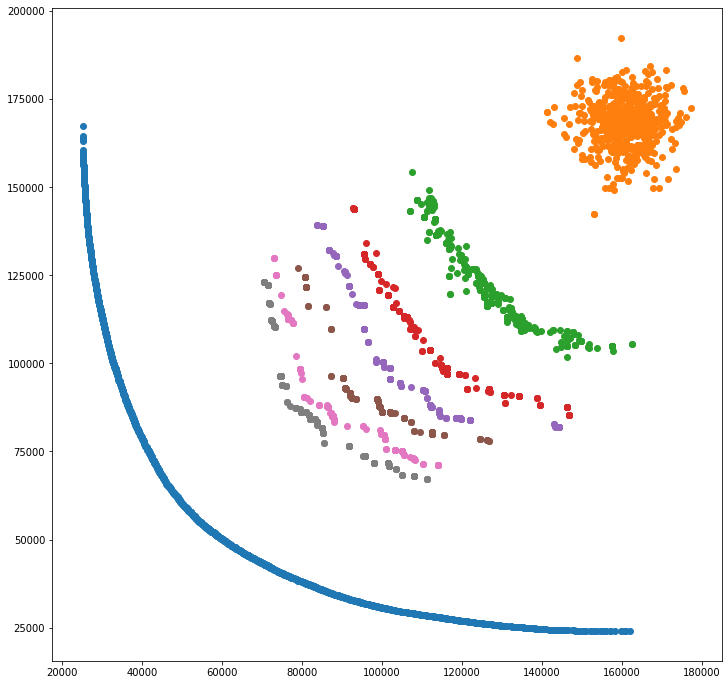

### Optymalizacja czasu

Czas wykonywania poszczególnych faz algorytmu przed optymalizacją.  
Jak widać największym problemem jest Non dominated sort, który na dodatek rośnie kwadratowo.

Initialization: 
         Non dominated sort:          2.766256093978882
         Distance assignment:         0.0017406940460205078

Iteration number:                     0

     Selection:                       0.01419210433959961
     Recombination:                   0.27422285079956055
     Mutation:                        0.003378152847290039
     Population evaluation:           0.12600994110107422
     Population replacement:
         Non dominated sort:          10.295392513275146
         Distance assignment:         0.0015685558319091797
     Population replacement - sum:    10.299115419387817

Iteration - sum:                      10.717824459075928

Iteration number:                     1

     Selection:                       0.019649982452392578
     Recombination:                   0.26890063285827637
     Mutation:                        0.006953239440917969
     Population evaluation:           0.12929415702819824
     Population replacement:
         Non dominated sor

Optymalizacja:  

*   Użycie CUDA do sortowania oraz ewaluacji populacji
*   Reimplementacja PMX (obecna wersja jest autorstwa Huberta Obrzuta)
*   Losowanie osobników do turniejów binarnych ze zwracaniem i ewentualne powtarzanie losowania  (przykład niżej)

In [ ]:
def select_with_replacement(s):
    for i in range(s):
        t = np.zeros(2)
        while t[0] == t[1]:
            t = np.random.choice(s, 2, replace=True)

def select_without_replacement(s):
    for i in range(s):
        t = np.random.choice(s, 2, replace=False)

%time select_with_replacement(16384)
%time select_without_replacement(16384)

CPU times: user 483 ms, sys: 113 ms, total: 596 ms
Wall time: 481 ms
CPU times: user 3.97 s, sys: 0 ns, total: 3.97 s
Wall time: 3.97 s


Czas wykonywania poszczególnych faz algorytmu po optymalizacji.

Initialization: 
         Non dominated sort:          0.056609392166137695
         Distance assignment:         0.0021021366119384766

Iteration number:                     0

     Selection:                       0.01078343391418457
     Recombination:                   0.058889150619506836
     Mutation:                        0.003121614456176758
     Population evaluation:           0.001954793930053711
     Population replacement:
         Non dominated sort:          0.06720399856567383
         Distance assignment:         0.0017094612121582031
     Population replacement - sum:    0.07023930549621582

Iteration - sum:                      0.14593172073364258

Iteration number:                     1

     Selection:                       0.012668609619140625
     Recombination:                   0.0612332820892334
     Mutation:                        0.0035636425018310547
     Population evaluation:           0.0020551681518554688
     Population replacement:
         Non dom

### Po optymalizacji

Działanie algorytmu po optymalizacji dla problemu euclidAB100.  
  
Parametry:  
Wielkość populacji: 512  
Liczba dzieci: 512  
Liczba iteracji: 300  
  

Czas wykonywania: 25 sekund

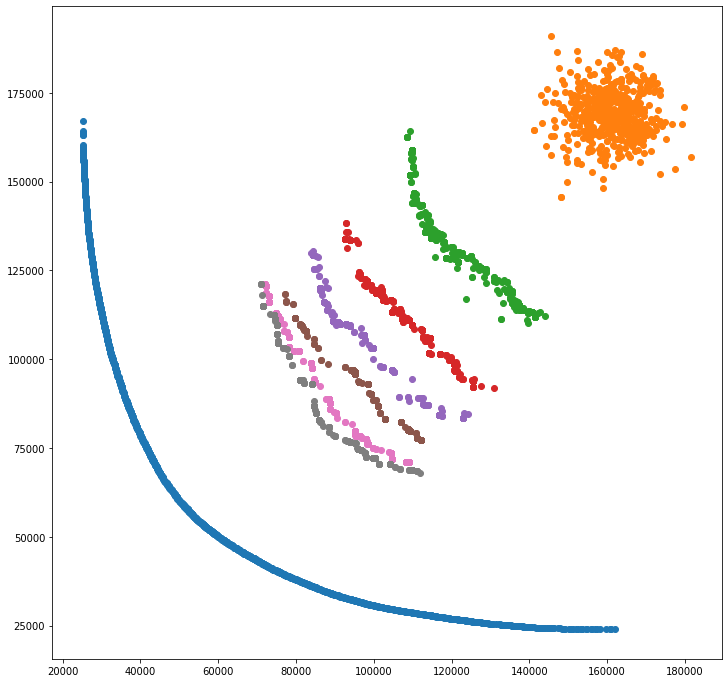

## Poszerzanie frontu pareto

### Przykład bez premii dla najlepszych osobników

Parametry:  
Wielkość populacji: 4096  
Liczba dzieci: 4096  
Liczba iteracji: 1000  

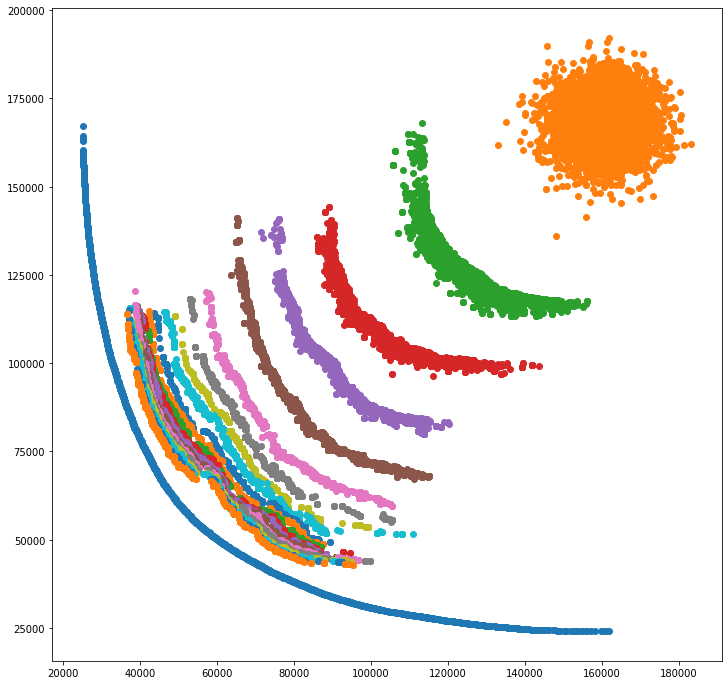

### Implementacja

Heurystyka:  
Wartości funkcji kryteriów dla dziecka często będą przyjmować wartości pośrednie pomiędzy  
wartościami funkcji kryteriów dla jego rodziców.  
  
Zatem gwarantując, że dla każdej funkcji celu znajdzie się część populacji która będzie  
miała dla niej bardzo dobry wynik, powinno udać się poszerzyć front pareto.

Robię to najpierw wybierając część populacji z najlepszym wynikiem dla każdej funkcji  
kryterium, a potem przeprowadzając non dominated sort na reszcie populacji.

#### Podejście pierwsze

Premiowane osobniki zawsze wygrywają turnieje.

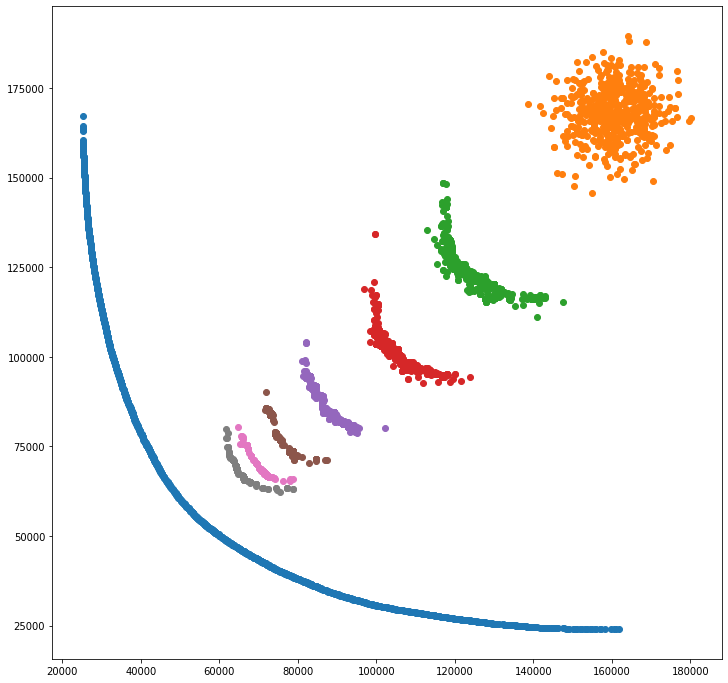

Jak widać ta metoda skutkuje tym, że populacja bardzo szybko staje się homogeniczna,  
nawet dla bardzo niewielu predmiowanych osobników.  
  
W rezultacie otrzymany wynik jest wprost przeciwny do oczekiwanego.

#### Podejście drugie

Osobniki premiowane zawsze przegrywają turnieje.

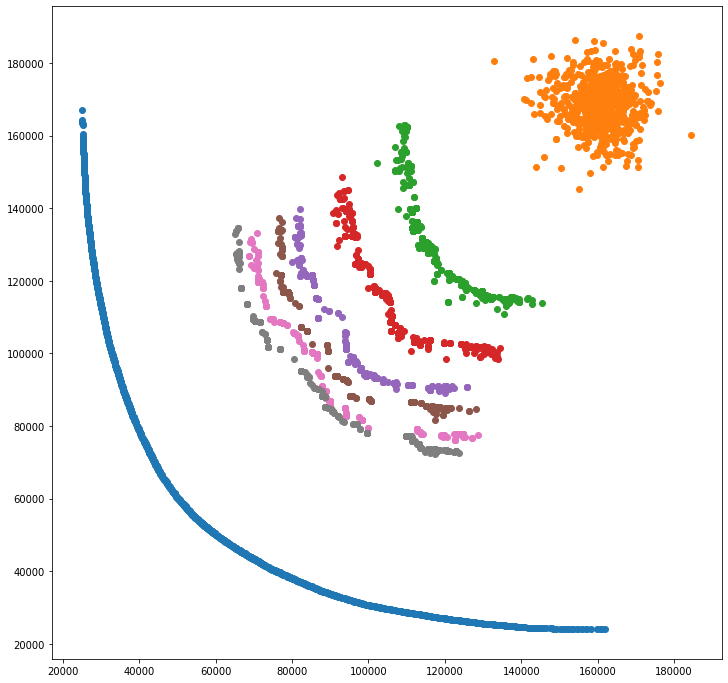

Ta metoda sprawdza się znacznie lepiej, front pareto jest wyraźnie szerszy.  
Warto wspomnieć, że wybór liczby premiowanych osobników jest bardzo istotny. Jeśli wartość ta jest zbyt duża, populacja skupia się w brzegach, a jeśli zbyt mała, nie osiągamy całej szerokości.

Przykład: Zbyt duża liczba premiowanych osobników

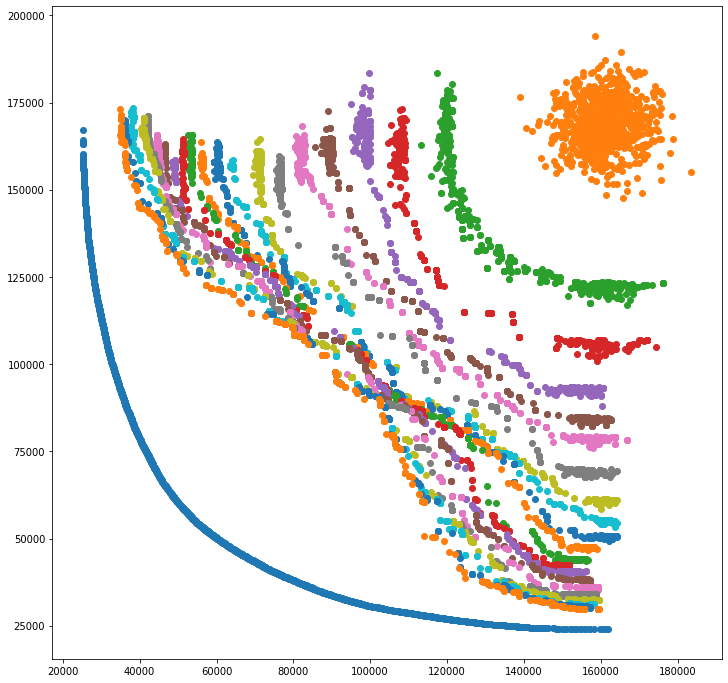

Przykład: Zbyt mała liczba premiowanych osobników

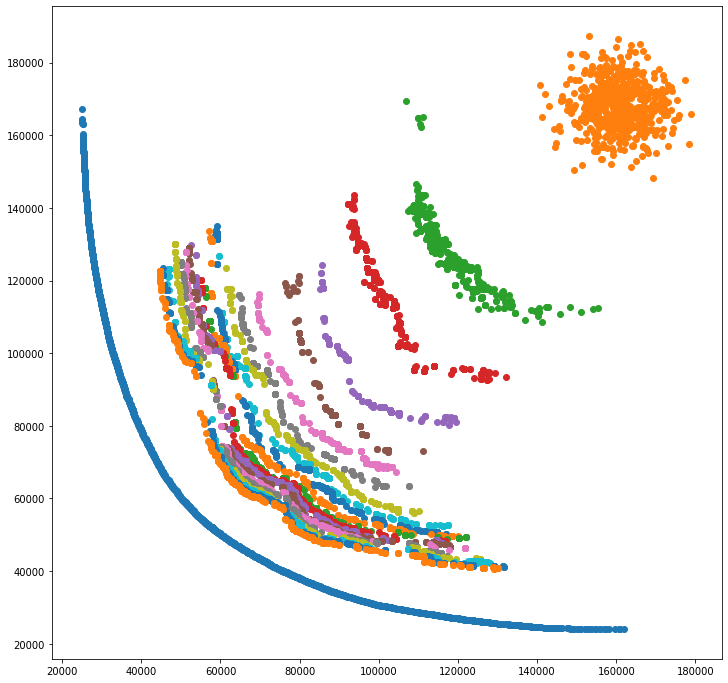

### Przykład z premią dla najlepszych osobników

Parametry:  
Wielkość populacji: 4096  
Liczba dzieci: 4096  
Liczba iteracji: 1000  
Liczba premiowanych osobników: 256

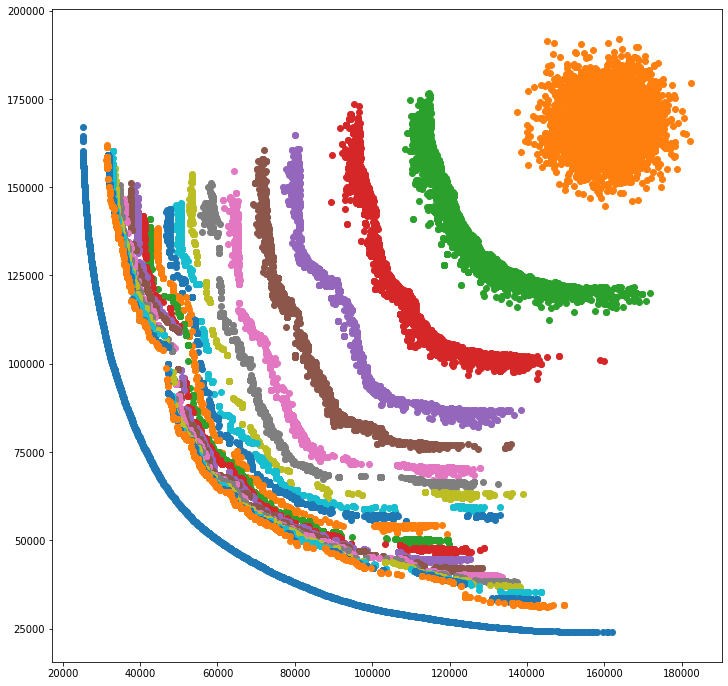

## Analiza problemów

In [133]:
def describe(current_population, vals_log, opt_vals, nameA, nameB, log_frequency=50):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 36))

    ax1.set_title('Progression of population')
    ax1.set_xlabel(nameA, size=20)
    ax1.set_ylabel(nameB, size=20)

    sns.scatterplot(x=opt_vals[:, 0], y=opt_vals[:, 1], edgecolor='none', ax=ax1)

    for vals in vals_log:
        sns.scatterplot(x=vals[:, 0], y=vals[:, 1], edgecolor='none', ax=ax1)

    hv_log = [hypervolume(vals, opt_vals) for vals in vals_log]

    ax2.set_title('Progression of hypervolume')
    ax2.set_xlabel('iteration', size=20)
    ax2.set_ylabel('hypervolume', size=20)

    sns.pointplot(x=(np.arange(len(hv_log))*log_frequency), y=hv_log, ax=ax2)
    hv_log[-1]

    used_edge_vals = set()
    for ind in current_population:
        for pos in ind:
            i, j = ind[pos-1], ind[pos]
            used_edge_vals.add((distance_matrix[0][i][j], distance_matrix[1][i][j]))

    used_x, used_y = [], []
    for i, j in used_edge_vals:
        used_x.append(i)
        used_y.append(j)

    all_edge_vals = set()
    for i in range(100):
        for j in range(100):
            if i != j:
                all_edge_vals.add((distance_matrix[0][i][j], distance_matrix[1][i][j]))

    all_x, all_y = [], []
    for i, j in all_edge_vals:
        all_x.append(i)
        all_y.append(j)

    ax3.set_title('Edges used by pareto frontier')
    ax3.set_xlabel(nameA, size=20)
    ax3.set_ylabel(nameB, size=20)

    sns.scatterplot(x=all_x, y=all_y, edgecolor='none', ax=ax3)
    sns.scatterplot(x=used_x, y=used_y, edgecolor='black', ax=ax3)

    return hv_log[-1]

In [82]:
def plot_route(ax, route, coords, name):
    
    sns.scatterplot(x=coords[:, 0], y=coords[:, 1], ax=ax)

    points = coords[route]
    points = np.append(points, [points[0]], axis=0)

    ax.add_line(Line2D(points[:, 0], points[:, 1]))

    ax.set_title(name)

In [124]:
def compare_graphs(frontier, vals, coordsA, coordsB, nameA, nameB):
    fig, ax = plt.subplots(3, 2, figsize=(12,18))

    best_A = np.argmin(vals[:, 0])
    route_A = frontier[best_A]
    plot_route(ax[0][0], route_A, coordsA, 'best_A ' + nameA)
    plot_route(ax[0][1], route_A, coordsB, 'best_A ' + nameB)

    best_B = np.argmin(vals[:, 1])
    route_B = frontier[best_B]
    plot_route(ax[2][0], route_B, coordsA, 'best_B ' + nameA)
    plot_route(ax[2][1], route_B, coordsB, 'best_B ' + nameB)

    z = (vals[best_A][0], vals[best_B][1])
    f = lambda v: max(v[0] - z[0], v[1] - z[1])
    f_min = f(vals[0])
    route_balanced = frontier[0]
    for i in range(vals.shape[0]):
        if f(vals[i]) < f_min:
            f_min = f(vals[i])
            route_balanced = frontier[i]

    plot_route(ax[1][0], route_balanced, coordsA, 'balanced ' + nameA)
    plot_route(ax[1][1], route_balanced, coordsB, 'balanced ' + nameB)



### euclidAB100

In [128]:
euclidA100 = tsplib95.load("euclidA100.tsp")
euclidB100 = tsplib95.load("euclidB100.tsp")

opt_vals = np.loadtxt('best.euclidAB100.tsp', dtype=int)

distance_matrix = generate_distance_matrix(100, euclidA100, euclidB100)
d_distance = cuda.to_device(distance_matrix)

In [129]:
coordsA = np.array(list(euclidA100.as_dict()['node_coords'].values()))
coordsB = np.array(list(euclidB100.as_dict()['node_coords'].values()))

In [131]:
np.random.seed(42)

chrom_len = 100
pop_size = 8192
obj_num = 2
n_iters = 2000
best_kept = 512
lf = n_iters//20

nsga_ii, vals_log = run_nsga_ii(chrom_len, pop_size, obj_num, n_iters, d_distance,
                                best_kept=best_kept, log_frequency=lf)

current_vals = nsga_ii.get_values()
vals_log.append(current_vals)

Hypervolume of found frontier:  0.9402543824583819


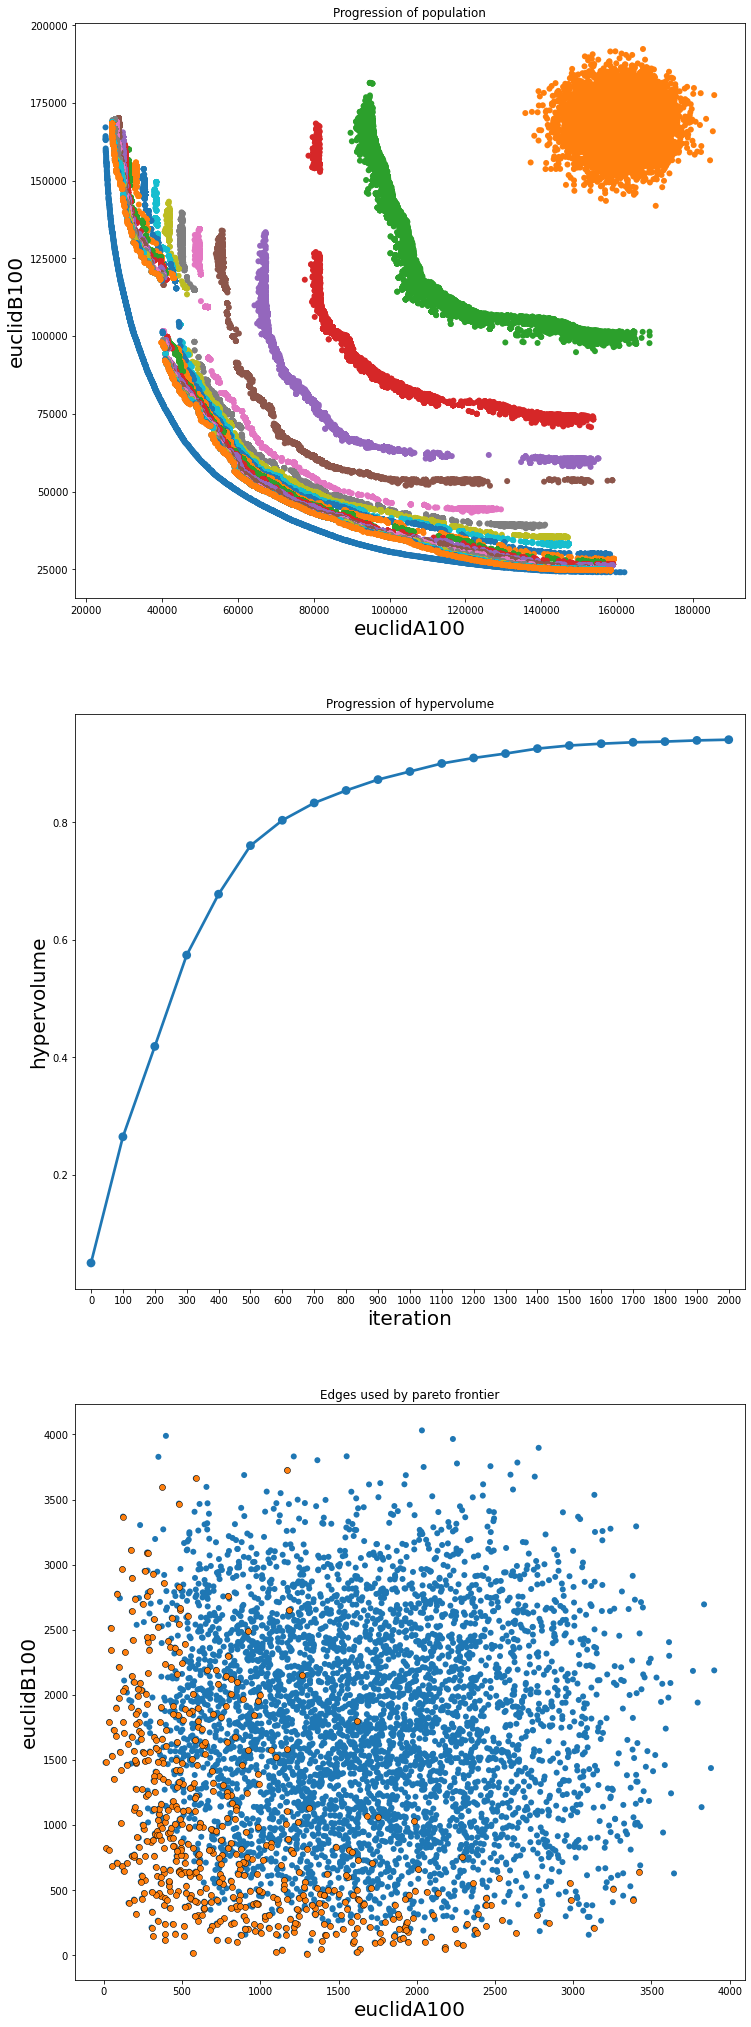

In [134]:
hv = describe(nsga_ii.current_population, vals_log, opt_vals, 'euclidA100', 'euclidB100',
              log_frequency=lf)
print('Hypervolume of found frontier: ', hv)

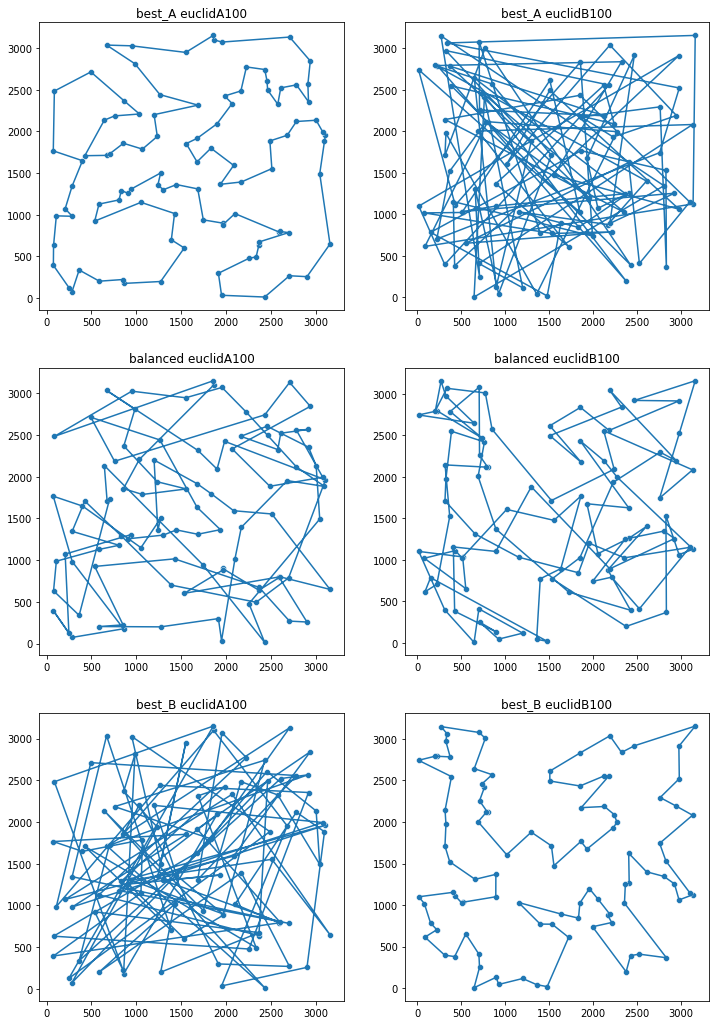

In [135]:
compare_graphs(nsga_ii.current_population, nsga_ii.current_objective_values,
               coordsA, coordsB, 'euclidA100', 'euclidB100')

### euclidAB300

In [14]:
euclidA300 = tsplib95.load("euclidA300.tsp")
euclidB300 = tsplib95.load("euclidB300.tsp")

opt_vals = np.loadtxt('best.euclidAB300.tsp', dtype=int)

distance_matrix = generate_distance_matrix(300, euclidA300, euclidB300)
d_distance = cuda.to_device(distance_matrix)

In [ ]:
np.random.seed(42)

chrom_len = 300
pop_size = 8192
obj_num = 2
n_iters = 3000
best_kept = 512
lf = n_iters//20

nsga_ii, vals_log = run_nsga_ii(chrom_len, pop_size, obj_num, n_iters, d_distance,
                                best_kept=best_kept, log_frequency=lf)

current_vals = nsga_ii.get_values()
vals_log.append(current_vals)

Hypervolume of found frontier:  0.6768620423320317


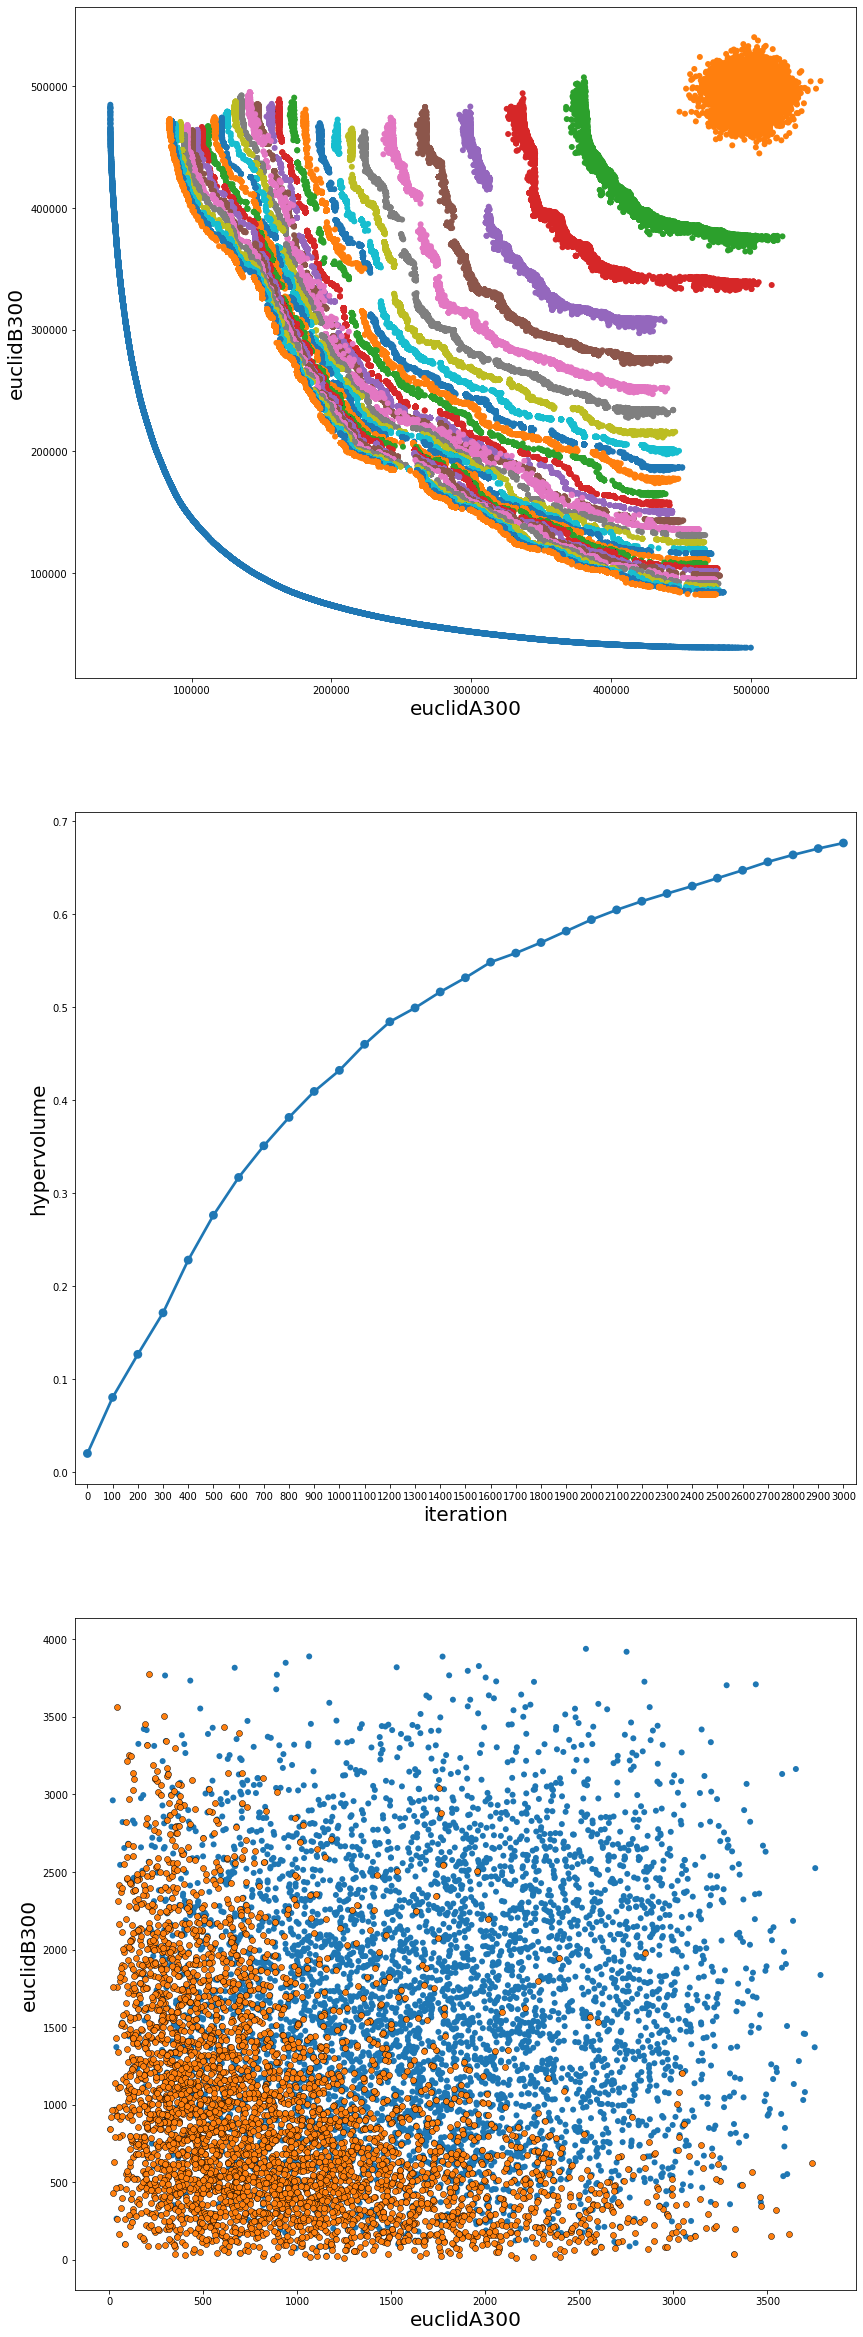

In [ ]:
hv = describe(nsga_ii.current_population, vals_log, opt_vals, 'euclidA300', 'euclidB300',
              log_frequency=lf)
print('Hypervolume of found frontier: ', hv)